<a href="https://colab.research.google.com/github/samaneh-m/Monte-Carlo-simulation/blob/main/main_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install "bayesflow>=2.0"
!pip install tensorflow
!pip install hmmlearn
!pip install scikit-learn
!pip install pandas matplotlib scipy


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"


In [ ]:
import tensorflow as tf
import bayesflow as bf
import hmmlearn

print("TensorFlow version:", tf.__version__)
print("BayesFlow version:", bf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))


INFO:bayesflow:Using backend 'tensorflow'


TensorFlow version: 2.19.0
BayesFlow version: 2.0.7
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm


In [ ]:
#Define the HMM data-generating process
class HMMHiddenStateSimulator:
    def __init__(self, seq_len=50):
        self.seq_len = seq_len

        # Transition probabilities
        self.transmat = np.array([
            [0.90, 0.10],
            [0.05, 0.95]
        ])

        # Initial state distribution
        self.startprob = np.array([0.0, 1.0])

        # Emission probabilities (20 amino acids)
        emissions = {
            'alpha': np.array([12,6,3,5,1,9,5,4,2,7,12,6,3,4,2,5,4,1,3,6]) / 100,
            'other': np.array([6,5,5,6,2,5,3,9,3,5,8,6,2,4,6,7,6,1,4,7]) / 100
        }

        self.emissionprob = np.stack([
            emissions['alpha'],
            emissions['other']
        ])

        self.model = hmm.CategoricalHMM(
            n_components=2,
            n_iter=100,
            init_params=""
        )

        self.model.startprob_ = self.startprob
        self.model.transmat_ = self.transmat
        self.model.emissionprob_ = self.emissionprob

    def sample(self, n_sequences=1):
        X, Z = [], []
        for _ in range(n_sequences):
            obs, states = self.model.sample(self.seq_len)
            X.append(obs.flatten())
            Z.append(states.flatten())

        return np.array(X), np.array(Z)


In [ ]:
#Sanity check the simulator
sim = HMMHiddenStateSimulator(seq_len=50)
x, z = sim.sample(n_sequences=5)

print("Observations shape:", x.shape)
print("Hidden states shape:", z.shape)
print("First hidden state sequence:")
print(z[0])


Observations shape: (5, 50)
Hidden states shape: (5, 50)
First hidden state sequence:
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


Step 2 — Define the estimand (what we estimate)

2.1 What is our target quantity?

From our HMM, each sequence has hidden states

Zi,1​,…,Zi,T​∈{0,1}


We define the helix probability per sequence as:

θi​=T1​t=1∑T​Zi,t​


This is: a Monte Carlo estimand

scalar per sequence


In [ ]:
#Implement the estimand
def helix_probability(hidden_states):
    """
    hidden_states: array of shape (n_sequences, seq_len)
    returns: array of shape (n_sequences,)
    """
    return hidden_states.mean(axis=1)


In [ ]:
#Sanity check on simulated data
theta = helix_probability(z)

print("Helix probabilities:")
print(theta)
print("Range:", theta.min(), theta.max())


Helix probabilities:
[0.72 0.58 0.92 0.88 1.  ]
Range: 0.58 1.0


Step 3 — Pure Monte Carlo estimation of helix probability (NO BayesFlow)

In this step we:

estimate θ via Monte Carlo

study convergence as N increases

still no inference, no neural nets

This corresponds to Person A (Convergence) in my comparison document.

In [ ]:
#Monte Carlo estimator for θ
def monte_carlo_helix_estimate(simulator, N, seq_len=50):
    """
    simulator: HMMHiddenStateSimulator
    N: number of simulated sequences
    returns: MC estimate of helix probability (scalar)
    """
    _, hidden_states = simulator.sample(n_sequences=N)
    theta = helix_probability(hidden_states)
    return theta.mean()


In [ ]:
#MC convergence experiment
Ns = [50, 100, 200, 500, 1000, 2000]
mc_estimates = []

sim = HMMHiddenStateSimulator(seq_len=50)

for N in Ns:
    est = monte_carlo_helix_estimate(sim, N)
    mc_estimates.append(est)
    print(f"N={N:4d}  MC estimate={est:.4f}")


N=  50  MC estimate=0.6604
N= 100  MC estimate=0.7078
N= 200  MC estimate=0.6927
N= 500  MC estimate=0.7048
N=1000  MC estimate=0.7190
N=2000  MC estimate=0.7097


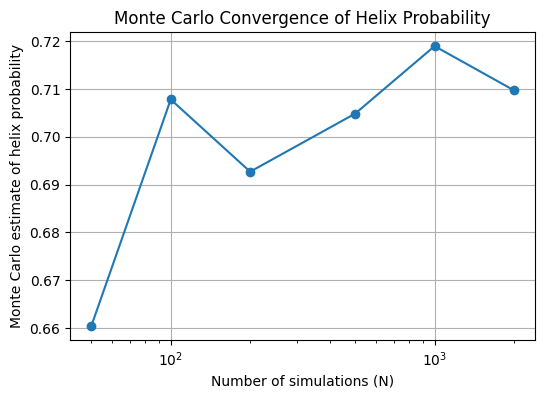

In [ ]:
#Plot convergence
plt.figure(figsize=(6,4))
plt.plot(Ns, mc_estimates, marker='o')
plt.xscale("log")
plt.xlabel("Number of simulations (N)")
plt.ylabel("Monte Carlo estimate of helix probability")
plt.title("Monte Carlo Convergence of Helix Probability")
plt.grid(True)
plt.show()


up to this point we have now cleanly implemented Person A’s first result.

Step 4 — Monte Carlo variance vs sample size 𝑁


Now we quantify convergence, not just visualize it.

This step directly connects to:

Law of Large Numbers

CLT

our comparison document (variance decay∼1/N)

In [ ]:
#Estimate Monte Carlo variance at fixed 𝑁
def mc_variance_estimate(simulator, N, R=50):
    """
    Estimate variance of MC estimator by repetition.

    simulator: HMMHiddenStateSimulator
    N: number of simulations per MC run
    R: number of repeated MC runs
    """
    estimates = []
    for _ in range(R):
        est = monte_carlo_helix_estimate(simulator, N)
        estimates.append(est)
    return np.var(estimates, ddof=1)


In [ ]:
#Compute variance for increasing N
Ns = [50, 100, 200, 500, 1000, 2000]
variances = []

sim = HMMHiddenStateSimulator(seq_len=50)

for N in Ns:
    var_N = mc_variance_estimate(sim, N, R=50)
    variances.append(var_N)
    print(f"N={N:4d}  Var={var_N:.6f}")


N=  50  Var=0.000684
N= 100  Var=0.000269
N= 200  Var=0.000238
N= 500  Var=0.000088
N=1000  Var=0.000051
N=2000  Var=0.000017


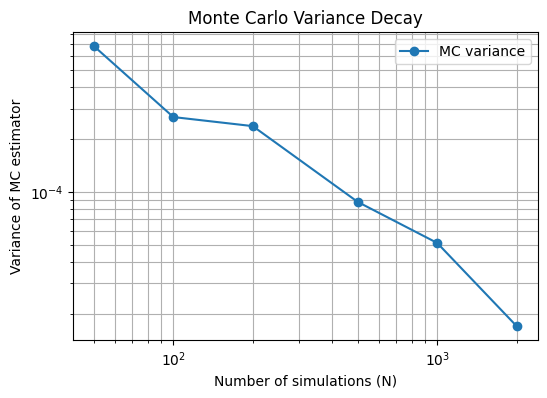

In [ ]:
#Plot variance decay
plt.figure(figsize=(6,4))
plt.plot(Ns, variances, marker='o', label="MC variance")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of simulations (N)")
plt.ylabel("Variance of MC estimator")
plt.title("Monte Carlo Variance Decay")
plt.grid(True, which="both")
plt.legend()
plt.show()


At this point, Person A (Convergence) is fully implemented and defensible.

Step 5 — Bootstrap uncertainty quantification (finite-sample view)

Here we do NOT increase N.
Instead, we ask:

Given a fixed Monte Carlo sample size, how uncertain is the estimate?

This directly complements Step 4.

In [ ]:
#Fix a realistic Monte Carlo sample size
N_fixed = 500


In [ ]:
#Generate one Monte Carlo sample
sim = HMMHiddenStateSimulator(seq_len=50)
_, hidden_states = sim.sample(n_sequences=N_fixed)

theta_samples = helix_probability(hidden_states)
theta_hat = theta_samples.mean()

print("Point estimate (MC mean):", theta_hat)


Point estimate (MC mean): 0.7066800000000001


In [ ]:
#Bootstrap the estimator
def bootstrap_ci(data, B=1000, alpha=0.05):
    """
    data: array of helix probabilities (length N)
    returns: lower CI, upper CI
    """
    N = len(data)
    boot_means = []

    for _ in range(B):
        resample = np.random.choice(data, size=N, replace=True)
        boot_means.append(resample.mean())

    lower = np.percentile(boot_means, 100 * alpha / 2)
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))

    return lower, upper, boot_means


In [ ]:
#Compute bootstrap CI
ci_lower, ci_upper, boot_means = bootstrap_ci(theta_samples)

print(f"95% Bootstrap CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print("CI width:", ci_upper - ci_lower)


95% Bootstrap CI: [0.6878, 0.7251]
CI width: 0.03725899999999993


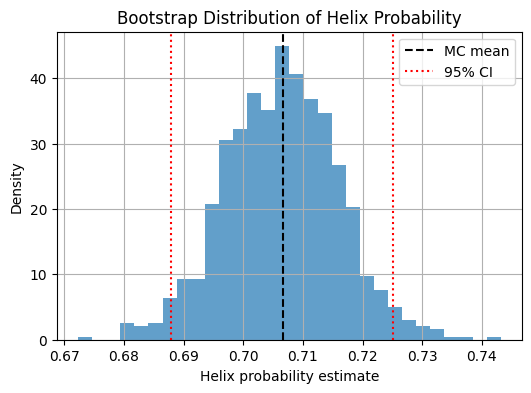

In [ ]:
#Visualize bootstrap distribution
plt.figure(figsize=(6,4))
plt.hist(boot_means, bins=30, density=True, alpha=0.7)
plt.axvline(theta_hat, color='black', linestyle='--', label="MC mean")
plt.axvline(ci_lower, color='red', linestyle=':')
plt.axvline(ci_upper, color='red', linestyle=':', label="95% CI")
plt.xlabel("Helix probability estimate")
plt.ylabel("Density")
plt.title("Bootstrap Distribution of Helix Probability")
plt.legend()
plt.grid(True)
plt.show()


Step 6 — Core comparison: Variance vs CI width


We now connect:

MC variance decay (Person A)

Bootstrap CI width shrinkage (Person B)

using the same estimator.

In [ ]:
#Bootstrap CI width for increasing 𝑁
Ns = [50, 100, 200, 500, 1000]
ci_widths = []

sim = HMMHiddenStateSimulator(seq_len=50)

for N in Ns:
    _, hidden_states = sim.sample(n_sequences=N)
    theta_samples = helix_probability(hidden_states)

    ci_l, ci_u, _ = bootstrap_ci(theta_samples, B=1000)
    width = ci_u - ci_l
    ci_widths.append(width)

    print(f"N={N:4d}  CI width={width:.4f}")


N=  50  CI width=0.1216
N= 100  CI width=0.0838
N= 200  CI width=0.0517
N= 500  CI width=0.0385
N=1000  CI width=0.0260


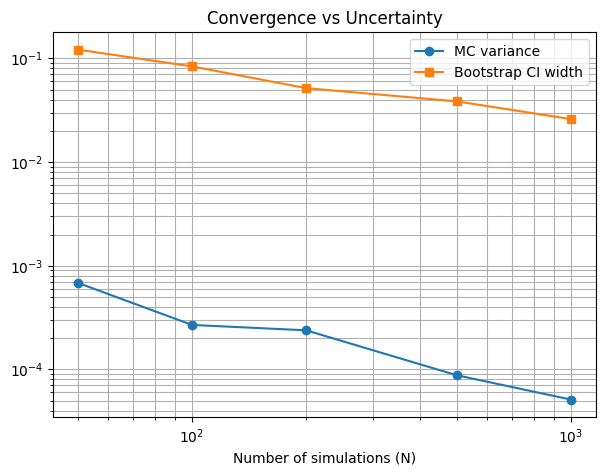

In [ ]:
#Side-by-side comparison plot (shared figure)
plt.figure(figsize=(7,5))

plt.plot(Ns, variances[:len(Ns)], marker='o', label="MC variance")
plt.plot(Ns, ci_widths, marker='s', label="Bootstrap CI width")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of simulations (N)")
plt.title("Convergence vs Uncertainty")
plt.grid(True, which="both")
plt.legend()
plt.show()
